In [1]:
import pandas as pd
import numpy as np
import sqlite3

## Database Access and Data Retrieval

In [2]:
conn = sqlite3.connect('../res/data/tables.sql')
cursor = conn.cursor()

In [3]:
# # ['id', 'school', 'gender', 'age', 'home address', 'parents cohabitation', 'moms education', 'dads education', 'moms job', 'dads job', 'choice reason', 'guardian', 'travel time', 'nursery education', 'internet access', 'higher education', 'significant other', 'household size', 'family relationship', 'free time', 'social activities', 'study time', 'first periods grade', 'second periods grade', 'third periods grade','failures', 'absences', 'health', 'weekday drinker', 'weekend drinker', 'drinker']
 
cursor.execute('''
SELECT profile_encoded.id, school, gender, age, "home address", "parents cohabitation", 
"moms education", "dads education", "moms job", "dads job", "choice reason", 
guardian, "travel time", "nursery education", "internet access", "higher education",
"significant other", "household size", "family relationship", "free time",
"social activities", "study time", "first periods grade", "second periods grade",
"third periods grade", failures, absences, health, "weekday drinking",
"weekend drinking", "heavy drinking"
FROM profile_encoded
JOIN activities_encoded
ON profile_encoded.id = activities_encoded.id
''')

row = cursor.fetchall()
description = cursor.description
conn.close()

In [4]:
df = pd.DataFrame(data=row, columns=map(lambda x: x[0], description))
df = df.set_index('id')
df.head()

,school,gender,age,home address,parents cohabitation,moms education,dads education,moms job,dads job,choice reason,...,study time,first periods grade,second periods grade,third periods grade,failures,absences,health,weekday drinking,weekend drinking,heavy drinking
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,18,1,0,4,4,0,2,0,...,2,0,0,0,0,6,3,1,1,0
2,0,1,17,1,1,1,1,0,4,0,...,2,0,0,0,0,4,3,1,1,0
3,0,1,15,1,1,1,1,0,4,4,...,2,0,0,1,3,10,3,2,3,1
4,0,1,15,1,1,4,2,1,3,1,...,3,1,1,1,0,2,5,1,1,0
5,0,1,16,1,1,3,3,4,4,1,...,2,0,1,1,0,4,5,1,2,0


In [5]:
df.nunique()

school                   2
gender                   2
age                      8
home address             2
parents cohabitation     2
moms education           5
dads education           5
moms job                 5
dads job                 5
choice reason            4
guardian                 3
travel time              4
nursery education        2
internet access          2
higher education         2
significant other        2
household size           2
family relationship      5
free time                5
social activities        5
study time               4
first periods grade      2
second periods grade     2
third periods grade      2
failures                 4
absences                35
health                   5
weekday drinking         5
weekend drinking         5
heavy drinking           2
dtype: int64

## Data Modeling

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf

### Data Preparation

In [7]:
# Non-binary list

non_binary = ['age', 'guardian', 'failures', 'free time', 'travel time', 'social activities', 'study time', 'health', 'family relationship', 'moms job', 'dads job', 'moms education', 'dads education', 'choice reason']
non_binary_df = df[non_binary]
non_binary_df[:5]

,age,guardian,failures,free time,travel time,social activities,study time,health,family relationship,moms job,dads job,moms education,dads education,choice reason
id,,,,,,,,,,,,,,
1,18,0,0,3,2,4,2,3,4,0,2,4,4,0
2,17,1,0,3,1,3,2,3,5,0,4,1,1,0
3,15,0,3,3,1,2,2,3,4,0,4,1,1,4
4,15,0,0,2,1,2,3,5,3,1,3,4,2,1
5,16,1,0,3,1,2,2,5,4,4,4,3,3,1


In [8]:
non_binary_df.dtypes

age                    int64
guardian               int64
failures               int64
free time              int64
travel time            int64
social activities      int64
study time             int64
health                 int64
family relationship    int64
moms job               int64
dads job               int64
moms education         int64
dads education         int64
choice reason          int64
dtype: object

In [9]:
one_hot_enc = OneHotEncoder(sparse=False)
one_hot_df = pd.DataFrame(one_hot_enc.fit_transform(non_binary_df))
encoded_columns = one_hot_enc.get_feature_names_out(non_binary)
one_hot_df.columns = encoded_columns

# merge dataframes

encoded_df = df.join(one_hot_df)

# drop non-binary columns
encoded_df = encoded_df.drop(non_binary, axis=1)
encoded_df[:5]

,school,gender,home address,parents cohabitation,nursery education,internet access,higher education,significant other,household size,first periods grade,...,moms education_4,dads education_0,dads education_1,dads education_2,dads education_3,dads education_4,choice reason_0,choice reason_1,choice reason_3,choice reason_4
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,0,1,0,1,0,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,1,1,1,0,1,1,0,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,1,1,1,1,1,1,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,0,1,1,1,1,0,1,0,1,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [10]:
encoded_df = encoded_df.dropna()

In [11]:
encoded_df.nunique()

school                  2
gender                  2
home address            2
parents cohabitation    2
nursery education       2
                       ..
dads education_4        2
choice reason_0         2
choice reason_1         2
choice reason_3         2
choice reason_4         2
Length: 83, dtype: int64

### Features (Inputs) and Target(s) (Output) 

In [48]:
# features = ['school', 'gender', 'age', 'home address', 'parents cohabitation', 'moms education', 'dads education', 'moms job', 'dads job', 'choice reason', 'guardian', 'travel time', 'nursery education', 'higher education', 'significant other', 'household size', 'family relationship', 'free time', 'social activities', 'study time','failures', 'absences', 'health', 'weekday drinker', 'weekend drinker']
# features = ['school', 'gender', 'age', 'home address', 'parents cohabitation', 'moms education', 'dads education', 'moms job', 'dads job', 'choice reason', 'guardian', 'travel time', 'nursery education', 'internet access', 'higher education', 'significant other', 'household size', 'family relationship', 'free time', 'social activities', 'study time', 'first periods grade', 'second periods grade', 'third periods grade','failures', 'absences', 'health'] 
# features = ['school', 'gender', 'age', 'home address', 'parents cohabitation', 'moms education', 'dads education', 'moms job', 'dads job', 'choice reason', 'guardian', 'travel time', 'nursery education', 'internet access', 'higher education', 'significant other', 'household size', 'family relationship', 'free time', 'social activities', 'study time','failures', 'absences', 'health'] 
features = encoded_df.columns
features = features.drop(['heavy drinking', 'weekend drinking', 'weekday drinking', 'absences'])
# features = list(features)
output = 'heavy drinking'

X = encoded_df[features]
y = encoded_df[output]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [49]:
len(features)

79

### Utility Functions

In [94]:
def feature_rank(values, columns, sort=True):
    """
    Pairs up feature names with their importance values
    
    Parameters
        values (numpy.array): array of floats from model.feature_importances_
        columns (list): list of column names from df.columns
        sort (boolean): sort list 
    
    Returns
        list of tuples containing tuples of (column-name, importance-value)
    """
    # creates an unordered list of tuple
    ranks = [(x,y) for x, y in zip(columns, values)]
    
    if(sort):
        # sorts in descending order
        return sorted(ranks, key=lambda x: x[1], reverse=True)
    else:
        return ranks

    
def matrix_dataframe(arg):
    return pd.DataFrame(data=arg, index=['Actual (Positive)', 'Actual (Negative)'], columns=['Predicted (True)', 'Predicted (False)'])


###  Data Scaled 

In [50]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Decision Tree Classifier

In [71]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_scaled, y_train)
X_train_scaled

array([[-0.59802917,  0.88392374,  0.61380825, ..., -0.56652091,
        -0.54681196, -0.31600531],
       [ 1.67215923,  0.88392374,  0.61380825, ..., -0.56652091,
        -0.54681196, -0.31600531],
       [-0.59802917,  0.88392374,  0.61380825, ..., -0.56652091,
         1.82878223, -0.31600531],
       ...,
       [-0.59802917,  0.88392374,  0.61380825, ...,  1.7651599 ,
        -0.54681196, -0.31600531],
       [-0.59802917, -1.13131931,  0.61380825, ..., -0.56652091,
        -0.54681196, -0.31600531],
       [-0.59802917, -1.13131931, -1.62917329, ...,  1.7651599 ,
        -0.54681196, -0.31600531]])

### Predictions (Decision Tree Classifier)

In [72]:
dt_predictions = dt_model.predict(X_test_scaled)
dt_predictions

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0],
      dtype=int64)

### The Predictive Accuracy (Decision Tree Classifier)

In [74]:
dt_acc_score = accuracy_score(y_test, dt_predictions)
dt_acc_score

0.7471264367816092

### Confusion Matrix (Decision Tree Classifier)

In [88]:
dt_conf_mat = confusion_matrix(y_test, dt_predictions)
dt_conf_mat

array([[110,  42],
       [ 24,  85]], dtype=int64)

In [96]:
matrix_dataframe(dt_conf_mat)

,Predicted (True),Predicted (False)
Actual (Positive),110,42
Actual (Negative),24,85


### Feature Importance Rank (Decision Tree Classifier)

In [76]:
ranks = feature_rank(dt_model.feature_importances_, features)
pd.Series(data=dict(ranks), name='feature importances')[:15]  # Top 15

gender                   0.063431
second periods grade     0.048261
moms education_3         0.033588
health_4                 0.032432
social activities_2      0.029880
dads job_3               0.029386
moms job_4               0.028653
guardian_0               0.026859
dads job_4               0.025961
dads education_2         0.023588
nursery education        0.023275
household size           0.022154
age_17                   0.020979
family relationship_5    0.020930
failures_3               0.020717
Name: feature importances, dtype: float64

### Classification Report (Decision Tree Classifier)

In [79]:
print(classification_report(y_test, dt_predictions))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       152
           1       0.67      0.78      0.72       109

    accuracy                           0.75       261
   macro avg       0.75      0.75      0.74       261
weighted avg       0.76      0.75      0.75       261



## Random Forest Classifier

In [80]:
rf_model = RandomForestClassifier(n_estimators=128, random_state=25)
rf_model.fit(X_train_scaled, y_train)
X_train_scaled

array([[-0.59802917,  0.88392374,  0.61380825, ..., -0.56652091,
        -0.54681196, -0.31600531],
       [ 1.67215923,  0.88392374,  0.61380825, ..., -0.56652091,
        -0.54681196, -0.31600531],
       [-0.59802917,  0.88392374,  0.61380825, ..., -0.56652091,
         1.82878223, -0.31600531],
       ...,
       [-0.59802917,  0.88392374,  0.61380825, ...,  1.7651599 ,
        -0.54681196, -0.31600531],
       [-0.59802917, -1.13131931,  0.61380825, ..., -0.56652091,
        -0.54681196, -0.31600531],
       [-0.59802917, -1.13131931, -1.62917329, ...,  1.7651599 ,
        -0.54681196, -0.31600531]])

### Predictions (Random Forest Classifier)

In [81]:
rf_predictions = rf_model.predict(X_test_scaled)
rf_predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0],
      dtype=int64)

### The Predictive Accuracy (Random Forest Classifier)

In [82]:
rf_acc_score = accuracy_score(y_test, rf_predictions)
rf_acc_score

0.8122605363984674

### Confusion Matrix (Random Forest Classifier)

In [92]:
rf_conf_mat = confusion_matrix(y_test, rf_predictions)
rf_conf_mat

array([[135,  17],
       [ 32,  77]], dtype=int64)

In [97]:
matrix_dataframe(rf_conf_mat)

,Predicted (True),Predicted (False)
Actual (Positive),135,17
Actual (Negative),32,77


### Feature Importance Rank (Random Forest Classifier)

In [84]:
ranks = feature_rank(rf_model.feature_importances_, features)
pd.Series(dict(ranks), name='feature importances')[:15]

gender                   0.050128
significant other        0.020476
household size           0.020323
free time_3              0.019587
study time_2             0.018834
choice reason_0          0.018816
nursery education        0.018690
second periods grade     0.018165
health_5                 0.017713
home address             0.017705
family relationship_4    0.017614
social activities_3      0.017598
moms job_4               0.017511
dads education_2         0.016913
free time_4              0.016836
Name: feature importances, dtype: float64

### Classification Report (Random Forest Classifier)

In [99]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       152
           1       0.82      0.71      0.76       109

    accuracy                           0.81       261
   macro avg       0.81      0.80      0.80       261
weighted avg       0.81      0.81      0.81       261



## Neural Network

In [24]:
# define the model

num_input_features = len(X_train_scaled[0])
hidden_nodes_layer_1 = 24
hidden_nodes_layer_2 = 12

nn = tf.keras.models.Sequential()

# first hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer_1, input_dim=num_input_features, activation='relu'))

# second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer_2, activation='relu'))

# outer layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

print(f'The model loss is {model_loss} and the accuracy is {model_accuracy}')

Epoch 1/50
25/25 [==============================] - 2s 4ms/step - loss: 0.6977 - accuracy: 0.5256
Epoch 2/50
25/25 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.5959
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6445
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6675
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6062 - accuracy: 0.6944
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5866 - accuracy: 0.7046
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5664 - accuracy: 0.7340
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5467 - accuracy: 0.7442
Epoch 9/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5273 - accuracy: 0.7545
Epoch 10/50
25/25 [==============================] - 0s 3ms/step - loss: 0.5081 - accuracy: 0.7685
Epoch 11/50
25/25 [

### Summary (Neural Network)

In [101]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                1920      
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 2,233
Trainable params: 2,233
Non-trainable params: 0
_________________________________________________________________


## Charts

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

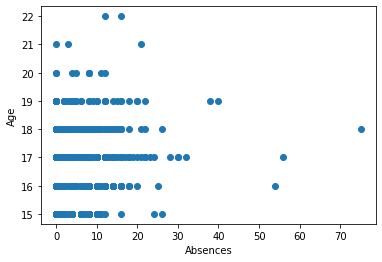

In [26]:
plt.scatter( df['absences'], df['age'])
plt.ylabel('Age')
plt.xlabel('Absences')
plt.show()

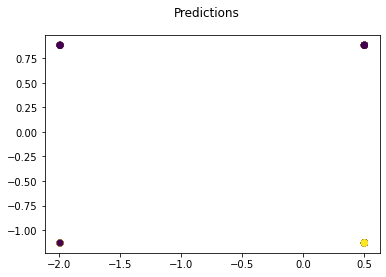

In [27]:
plt.scatter( X_test_scaled[:, 4], X_test_scaled[:, 1], c=y_test)
plt.suptitle('Predictions')
plt.show()


### Predictions
 - The purple dots represent drinkers predictions
 - The yellow dots represent non-drinkers predictions
 
#### The drinker section is on the right hand side and the non-drinker section is on the left hand side
 - The **lone yellow dot** (false drinker prediction) on the right hand side is a **false positive**
 - The **2 purple dots** (false non-drinker prediction) on the left hand side are **false negatives**